In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Gerekli kütüphaneleri yükledik.


# Balık Görüntüleri için Dosya Yolları ve Etiketlerin Toplanması

Bu kod, büyük ölçekli bir balık veri setindeki tüm görüntülerin dosya yollarını ve etiketlerini toplamak için kullanılır. Aşağıdaki adımlar izlenir:

1. **Kütüphanelerin İçe Aktarılması:** Gerekli olan kütüphaneler (`os` ve `pandas`) içe aktarılır.
2. **Değişkenlerin Tanımlanması:** 
   - `label`: Balık türlerini saklamak için bir liste.
   - `path`: Her görüntünün tam dosya yolunu saklamak için bir liste.
   - `fish_dir`: Veri setinin bulunduğu dizin.
   - `image_size`: Görüntü boyutları (224x224).
3. **Dosya Yürüyüşü:** `os.walk` kullanılarak belirtilen dizindeki tüm klasörler ve dosyalar taranır.
   - Sadece `.png` uzantılı dosyalar dikkate alınır.
   - `GT` içeren klasörler hariç tutulur.
   - Klasör adı `label` listesine, dosya yolu ise `path` listesine eklenir.
4. **DataFrame Oluşturma:** `path` ve `label` listeleri kullanılarak bir pandas DataFrame oluşturulur.
5. **Veri Setinin Gösterimi:** Veri setinin ilk birkaç satırı `head()` fonksiyonu ile yazdırılır.


In [9]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
image_size = (224, 224)

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Sadece .png dosyaları
            if 'GT' not in dir_name.split('/')[-1]:  # GT dosyalarını içermemesi şartı
                label.append(os.path.split(dir_name)[-1])  # Klasör ismini etiket olarak ekliyoruz
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu ekliyoruz

# DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Veri seti hazır. İlk birkaç satırı görelim:
print(data.head())


                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


# Veri Setinin Analizi

Bu kod parçası, balık veri setinin temel özelliklerini ve etiketlerin dağılımını analiz etmek için kullanılır. Aşağıdaki adımlar gerçekleştirilir:

1. **Veri Seti Boyutunun Görüntülenmesi:** Veri setinde toplam kaç adet görüntü olduğunu gösterir.
2. **Etiketlerin Dağılımı:** Her bir balık türünün sayısını içeren bir dağılım tablosu oluşturur.
3. **Eksik Veri Kontrolü:** Veri setinde eksik verilerin olup olmadığını kontrol eder.
4. **Balık Türlerinin Dağılım Grafiği:** Balık türlerinin sayısını gösteren bir çubuk grafiği oluşturur. 
   - `viridis` renk haritası kullanılarak her bir tür için farklı renkler atanır.

Aşağıda kod parçası verilmiştir:

Veri setinde toplam 9000 adet görüntü var.
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64
path     0
label    0
dtype: int64


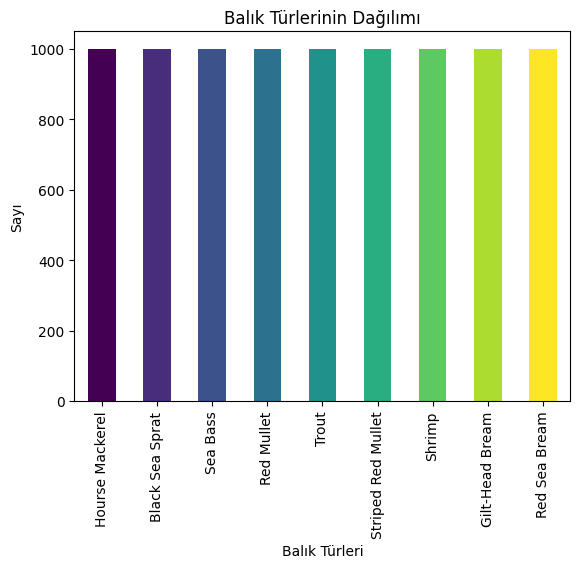

In [10]:
# Veri setinin boyutunu görmek
print(f"Veri setinde toplam {data.shape[0]} adet görüntü var.")

# Etiketlerin dağılımını görmek
print(data['label'].value_counts())

# Eksik veri kontrolü
print(data.isnull().sum())

counts = data['label'].value_counts()

colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))

counts.plot.bar(color=colors)
plt.title('Balık Türlerinin Dağılımı')
plt.xlabel('Balık Türleri')
plt.ylabel('Sayı')
plt.show()


# Rastgele Balık Görüntülerinin Görselleştirilmesi

Bu kod parçası, balık veri setinden rastgele seçilen 9 görüntüyü ve bunların etiketlerini görselleştirmek için kullanılır. Aşağıdaki adımlar izlenir:

1. **Kütüphanelerin İçe Aktarılması:** Gerekli olan kütüphaneler (`random`, `matplotlib.pyplot`, ve `tensorflow.keras.preprocessing.image`) içe aktarılır.
2. **Rastgele Görüntü Seçimi:** Veri setinden rastgele 9 görüntü ve etiketleri seçilir.
3. **Görüntülerin Yüklenmesi ve Gösterilmesi:** Her bir görüntü belirtilen boyutla yüklenir ve başlık olarak etiket bilgisi ile birlikte gösterilir.
4. **Görselleştirme:** Görüntüler 3x3'lük bir grid şeklinde yerleştirilir.

Aşağıda kod parçası verilmiştir:

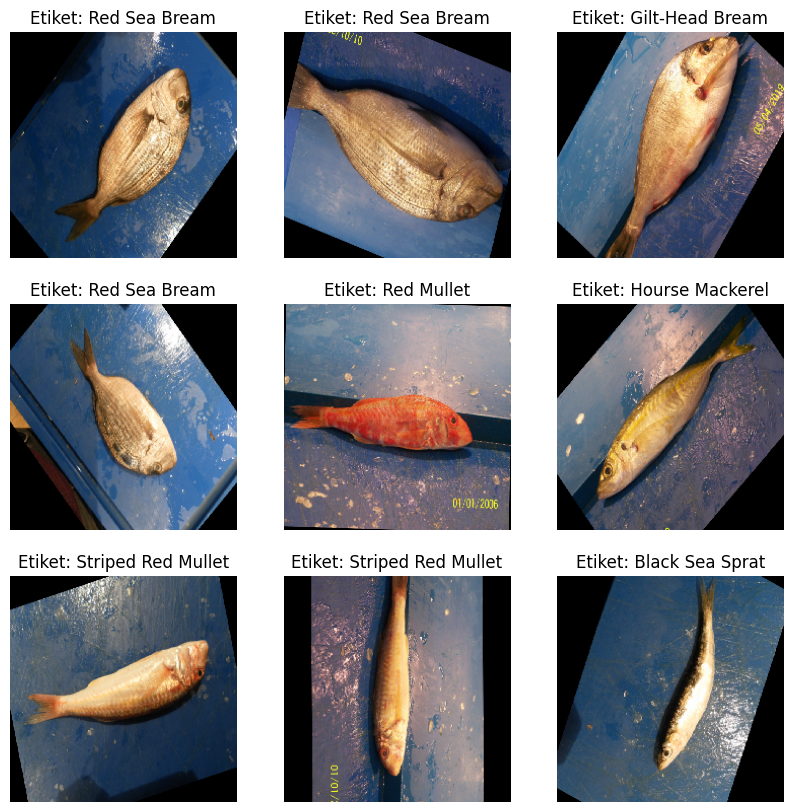

In [11]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Rastgele 9 görüntü ve etiketlerini görselleştirelim
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_index = random.randint(0, len(data)-1)
    img_path = data['path'].iloc[random_index]
    img_label = data['label'].iloc[random_index]
    
    img = load_img(img_path, target_size=image_size)  # Görüntüyü yüklüyoruz
    
    plt.imshow(img)
    plt.title(f"Etiket: {img_label}")
    plt.axis('off')

plt.show()


# Görüntülerin Yüklenmesi ve Ön İşleme

Bu kod parçası, balık veri setindeki görüntülerin boyutlandırılması, normalizasyonu ve etiketlerin one-hot encoding ile dönüştürülmesi işlemlerini gerçekleştirir. Aşağıdaki adımlar izlenir:

1. **Görüntü Boyutlandırma:** Görüntülerin boyutu 64x64 piksel olarak ayarlanır.
2. **Görüntü Yükleme ve Normalizasyon:** 
   - `load_and_preprocess_image` fonksiyonu, belirtilen dosya yolundaki görüntüyü yükler ve normalleştirir. 
   - Görüntüler 0-1 aralığına normalize edilir. 
   - Hata durumunda dosya yolu ve hata mesajı yazdırılır.
3. **Görüntülerin Yüklenmesi:** Veri setindeki tüm görüntüler yüklenir ve bir NumPy dizisi (array) haline getirilir.
4. **Eksik Görüntülerin Çıkarılması:** Yüklenemeyen görüntüler diziden çıkarılır.
5. **Etiketlerin One-Hot Encoding:** Balık türlerinin etiketleri one-hot encoding ile dönüştürülür.
6. **Verinin Train ve Test Olarak Ayrılması:** Veriler %80 eğitim ve %20 test olmak üzere ikiye ayrılır.
7. **Boyutların Kontrolü:** Eğitim ve test veri setlerinin boyutları yazdırılır.

Aşağıda kod parçası verilmiştir:

In [12]:
## Görüntülerin boyutu ve normalize edilmesi
image_size = (64, 64)  # Görüntü boyutu (64x64 px)

def load_and_preprocess_image(path):
    try:
        image = load_img(path, target_size=image_size)  # Görüntüyü yükleme ve boyutlandırma
        image = img_to_array(image) / 255.0  # Normalizasyon (0-1 arası)
        return image
    except Exception as e:
        print(f"Hata: {e}, dosya: {path}")  # Hata olursa dosya yolunu ve hatayı yazdırma
        return None

# Görüntülerin yüklenmesi
X = np.array([load_and_preprocess_image(p) for p in data['path']])

# Yüklenemeyen görüntüler varsa çıkaralım
X = np.array([img for img in X if img is not None])

# Etiketleri one-hot encode yapıyoruz
y = pd.get_dummies(data['label']).values  

# Veriyi train ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kontrol için boyutları yazdırma
print(f"X_train boyutu: {X_train.shape}")
print(f"y_train boyutu: {y_train.shape}")
print(f"X_test boyutu: {X_test.shape}")
print(f"y_test boyutu: {y_test.shape}")


X_train boyutu: (7200, 64, 64, 3)
y_train boyutu: (7200, 9)
X_test boyutu: (1800, 64, 64, 3)
y_test boyutu: (1800, 9)


# Sinir Ağı Modelinin Oluşturulması

Bu kod parçası, bir sinir ağı modelinin oluşturulması ve derlenmesi işlemlerini gerçekleştirir. Model, çeşitli katmanlar kullanarak görüntü sınıflandırma problemini çözmek için tasarlanmıştır. Aşağıdaki adımlar izlenir:

1. **Modelin Tanımlanması:** 
   - `Sequential()` model yapısı oluşturulur.
   - İlk olarak, görüntü verilerini düzleştiren bir `Flatten` katmanı eklenir. Giriş şekli 64x64 piksel boyutundaki 3 kanallı görüntülerdir.
   - Ardından, iki adet tam bağlantılı (`Dense`) katman eklenir. Bu katmanlarda `ReLU` aktivasyon fonksiyonu kullanılır.
   - Her bir `Dense` katmanından sonra `BatchNormalization` katmanı eklenerek modelin daha hızlı öğrenmesi sağlanır.
   - Ayrıca, aşırı öğrenmeyi önlemek için `Dropout` katmanları kullanılır. Bu katmanlar, rastgele bazı nöronları devre dışı bırakır.
   - Çıkış katmanı olarak `softmax` aktivasyon fonksiyonu kullanılan bir `Dense` katmanı eklenir; bu, çoklu sınıf sınıflandırma problemi için uygundur.

2. **Modelin Derlenmesi:** 
   - Model, `Adam` optimizasyon algoritması ve `categorical_crossentropy` kaybı ile derlenir. Bu, modelin sınıflandırma problemlerini çözmesini sağlar.
   - Ayrıca, `accuracy` metriği ile modelin performansı izlenir.

3. **Model Özeti:** Modelin katmanları ve parametre sayısı hakkında bilgi veren özet yazdırılır.

Aşağıda kod parçası verilmiştir:

In [13]:
# Modelin oluşturulması
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))  # Giriş katmanı
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.5))  # Dropout katmanı
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Çıkış katmanı (softmax)

# Modeli derleme
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özeti
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,428,681 (24.52 MB)

 Trainable params: 6,427,145 (24.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

# Sınıf Ağırlıklarının Hesaplanması ve Modelin Eğitilmesi

Bu kod parçası, sınıf dengesizliklerini ele almak için sınıf ağırlıklarını hesaplar ve ardından modelin eğitilmesi işlemini gerçekleştirir. Adımlar aşağıdaki gibidir:

1. **Sınıf Ağırlıklarının Hesaplanması:**
   - `class_weight.compute_class_weight` fonksiyonu kullanılarak her sınıf için ağırlıklar hesaplanır. Bu, modelin daha az temsil edilen sınıflara daha fazla önem vermesini sağlar.
   - Ağırlıklar, `np.unique` ile bulunan benzersiz sınıf etiketlerine ve `np.argmax` kullanarak elde edilen `y_train` etiketlerine göre hesaplanır.
   - Hesaplanan sınıf ağırlıkları bir sözlüğe (`class_weights_dict`) dönüştürülerek daha sonraki işlemlerde kullanılmak üzere saklanır.

2. **Modelin Eğitilmesi:**
   - Model, `fit` metodu ile eğitilir. Burada, eğitim verileri (`X_train`, `y_train`) kullanılarak model, belirtilen `epochs` sayısı boyunca eğitilir.
   - `batch_size` ile belirtilen grup büyüklüğünde veriler kullanılarak eğitme işlemi gerçekleştirilir.
   - Validation verileri (`X_test`, `y_test`) kullanılarak modelin performansı izlenir.
   - `class_weight` parametresi ile daha az temsil edilen sınıflara ek ağırlık verilerek modelin dengesiz veri seti ile daha iyi bir performans göstermesi hedeflenir.

Aşağıda kod parçası verilmiştir:

In [14]:
from sklearn.utils import class_weight

# Sınıf ağırlıklarını hesaplayalım
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(np.argmax(y_train, axis=1)),
                                                  y=np.argmax(y_train, axis=1))

# class_weights'i dictionary'e çevirme
class_weights_dict = dict(enumerate(class_weights))

# Modelin eğitilmesi
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dict)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.2926 - loss: 2.4466 - val_accuracy: 0.3561 - val_loss: 1.8407
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5177 - loss: 1.4634 - val_accuracy: 0.6644 - val_loss: 0.9571
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6262 - loss: 1.1142 - val_accuracy: 0.7506 - val_loss: 0.7849
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6850 - loss: 0.9359 - val_accuracy: 0.7339 - val_loss: 0.7577
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.7354 - loss: 0.7894 - val_accuracy: 0.8056 - val_loss: 0.5973
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.7487 - loss: 0.7284 - val_accuracy: 0.7789 - val_loss: 0.6367
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7793 - loss: 0.6442 - val_accuracy: 0.8111 - val_loss: 0.5364
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7820 - loss: 0.6317 - val_ac

# Kayıp ve Doğruluk Grafikleri

Bu kod parçası, modelin eğitim sürecinde kayıp (loss) ve doğruluk (accuracy) değerlerini görselleştirmek için kullanılır. Görselleştirme, modelin öğrenme sürecini anlamak ve model performansını değerlendirmek için önemlidir. Aşağıdaki adımlar gerçekleştirilir:

1. **Kayıp Grafiği:**
   - Eğitim kaybı (`loss`) ve doğrulama kaybı (`val_loss`) değerleri, her epoch için çizilir.
   - Bu grafik, modelin eğitim sürecindeki kayıp fonksiyonunun nasıl değiştiğini gösterir. Düşen bir kayıp değeri, modelin öğrenme sürecinde ilerlediğini gösterir.

2. **Doğruluk Grafiği:**
   - Eğitim doğruluğu (`accuracy`) ve doğrulama doğruluğu (`val_accuracy`) değerleri, her epoch için çizilir.
   - Bu grafik, modelin eğitim sürecindeki doğruluk oranının nasıl değiştiğini gösterir. Artan bir doğruluk oranı, modelin doğru sınıflandırma yeteneğinin arttığını gösterir.

Aşağıda kayıp ve doğruluk grafiklerinin çizildiği kod parçası verilmiştir:

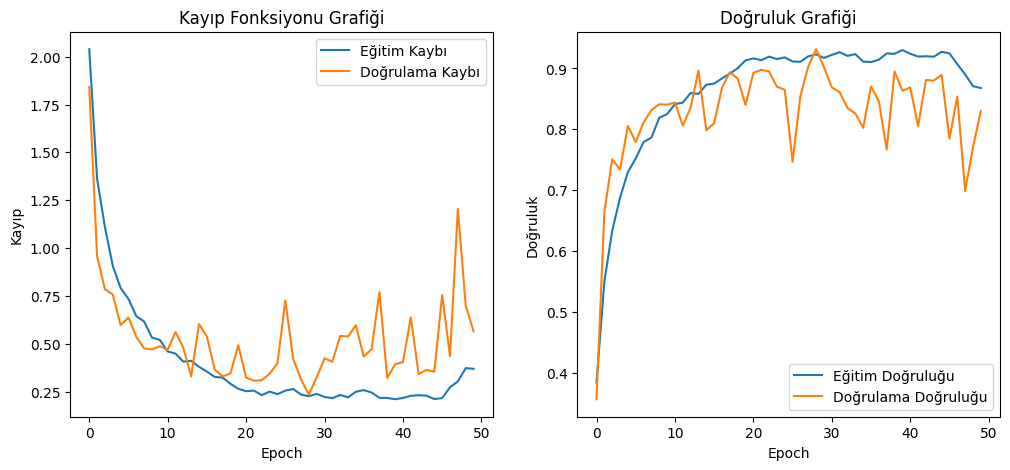

In [15]:
# Kayıp ve doğruluk grafikleri
plt.figure(figsize=(12, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Fonksiyonu Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


# Model Performans Değerlendirme: Confusion Matrix ve Sınıflandırma Raporu

1. **Confusion Matrix (Karmaşıklık Matrisi):**
   - Modelin her sınıf için doğru ve yanlış sınıflandırmalarını gösterir.
   - Matrisin her bir hücresi, modelin bir sınıfı diğer sınıflara göre kaç kez doğru veya yanlış tahmin ettiğini temsil eder.
   - Isı haritası (heatmap) şeklinde görselleştirilir.

2. **Classification Report (Sınıflandırma Raporu):**
   - Precision, recall, f1-score gibi önemli performans metriklerini içerir.
   - Her bir sınıf için modelin ne kadar iyi performans gösterdiği bu raporda detaylandırılır.

Aşağıda confusion matrix ve sınıflandırma raporunun üretildiği kod parçası verilmiştir:

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


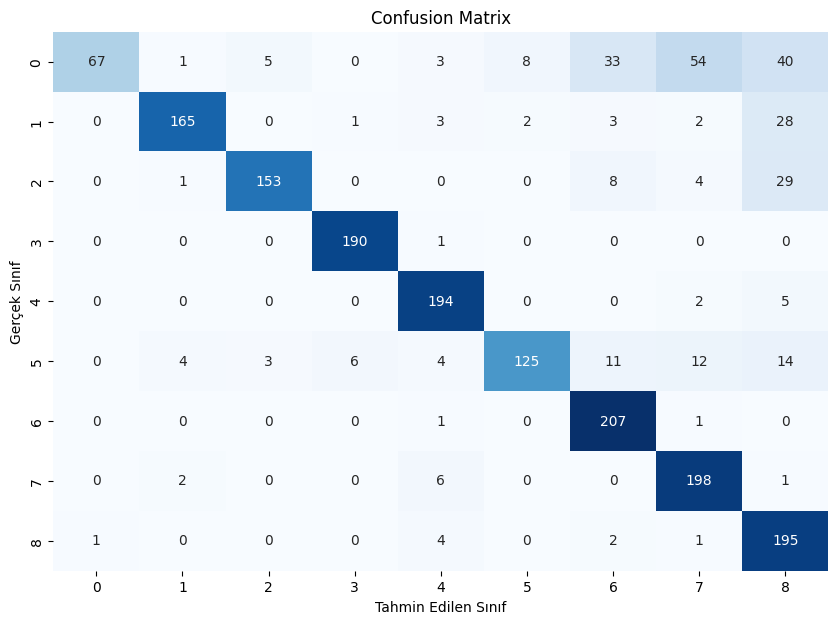

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.32      0.48       211
           1       0.95      0.81      0.88       204
           2       0.95      0.78      0.86       195
           3       0.96      0.99      0.98       191
           4       0.90      0.97      0.93       201
           5       0.93      0.70      0.80       179
           6       0.78      0.99      0.88       209
           7       0.72      0.96      0.82       207
           8       0.62      0.96      0.76       203

    accuracy                           0.83      1800
   macro avg       0.87      0.83      0.82      1800
weighted avg       0.87      0.83      0.82      1800



In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Test verileri üzerinden tahminler
y_pred = np.argmax(model.predict(X_test), axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_test, axis=1)  # Gerçek sınıflar

# Confusion Matrix (Karmaşıklık Matrisi)
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion matrix görselleştirme
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# Classification Report (Sınıflandırma Raporu)
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)
